## Background
---
Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level.

As players progress through the game, they will encounter gates that force them to wait some time before they can either progress or make an in-app purchase.

In this project, we will analyze the result of an A/B test in which the first gate was moved from level 30 to level 40. In particular, we will analyze the impact on the metrics of player retention and game rounds played.

### Data Description:
---
Our data is comprised of the 90,189 players that installed the game while the A/B test was running. The variables of interest are:

* ```userid``` - a unique number that identifies
each player.
* ```version``` - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
* ```sum_gamerounds``` - the number of game rounds played by the player during the first week after installation
* ```retention_1``` - did the player come back and play 1 day after installing?
* ```retention_7``` - did the player come back and play 7 days after installing?

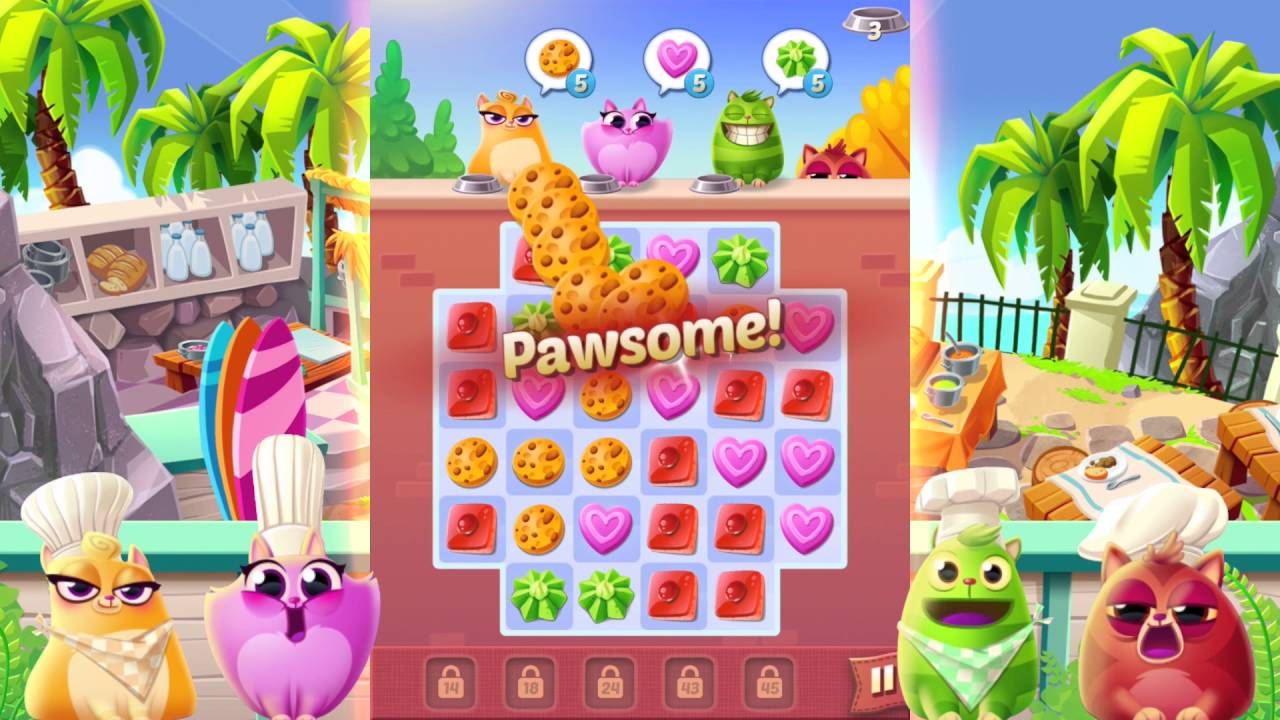

### A/B Testing Parameters
---

In an A/B test, a change is applied to a treatment group, and its performance is compared against a control group to estimate the impact of the change.

1. Performance Metric: ```sum_gamerounds```, ```retention_1```, ```retention_7```
2. Experimental Design: Sample size is large and data is easy to collect, thus Randomized Design
3. Unit Assignment: Each userid is randomly assigned to hit the limit at either ```gate_30``` or ```gate_40``` upon installing the game.
4. Sample Size and Duration: The test was run long enough to collect 90,189 userid's, which is presumably a large enough number to be a representative sample

The test itself will use hypothesis tests depending on the nature and satisfied assumptions of the observed data, as we will now explore.



# Setup


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import io

# Hypothesis Testing
from scipy.stats import shapiro
import scipy.stats as stats

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

## Load Dataset

In [ ]:
# Path if running through Colab
path = '/content/drive/MyDrive/cookie_cats.csv'

In [ ]:
df = pd.read_csv(path)
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 1. Data Cleaning

Before this stage, it would also be smart to verify randomization implementation. Ideally, the data compiled to comprise the treatment and control groups would have been sourced randomly to prevent confounders.

Since we only have the resulting data, the best we can do is a sanity check of the two groups' descriptive statistics.

In [ ]:
# Check for missing user IDs
print("Missing user IDs:", df['userid'].isnull().sum())

# Check for duplicate user IDs
print("Duplicate user IDs:", df['userid'].duplicated().sum())

# Check the number of users in each version
print("\nNumber of users in each version:")
print(df['version'].value_counts())

# Check the proportion of users in each version
print("\nProportion of users in each version:")
print(df['version'].value_counts(normalize=True))

Missing user IDs: 0
Duplicate user IDs: 0

Number of users in each version:
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

Proportion of users in each version:
version
gate_40   0.5044
gate_30   0.4956
Name: proportion, dtype: float64


In [ ]:
print("Descriptive statistics for sum_gamerounds by version:")
print(df.groupby('version')['sum_gamerounds'].describe())

Descriptive statistics for sum_gamerounds by version:
             count    mean      std    min    25%     50%     75%        max
version                                                                     
gate_30 44700.0000 52.4563 256.7164 0.0000 5.0000 17.0000 50.0000 49854.0000
gate_40 45489.0000 51.2988 103.2944 0.0000 5.0000 16.0000 52.0000  2640.0000


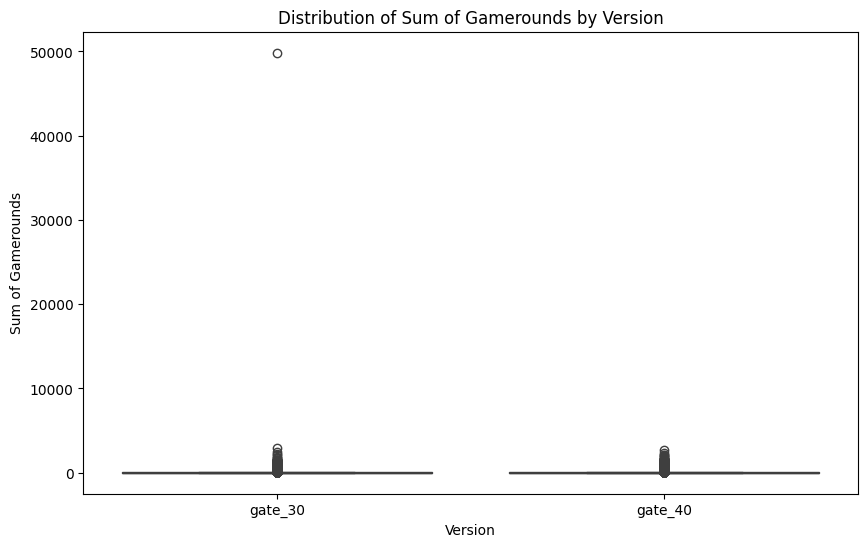

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='version', y='sum_gamerounds', data=df)
plt.title('Distribution of Sum of Gamerounds by Version')
plt.ylabel('Sum of Gamerounds')
plt.xlabel('Version')
plt.show()

Clearly there is at least one significant outlier in the gate_30 group. We'll explore how many there are, and determine how to mitigate it before moving onto hypothesis testing.

In [ ]:
df['sum_gamerounds'].sort_values(ascending=False).head(10)

,sum_gamerounds
57702,49854
7912,2961
29417,2640
43671,2438
48188,2294
46344,2251
87007,2156
36933,2124
88328,2063
6536,2015


There is only one significant outlier at 49854. Let's refer to the dataset context to determine how to deal with it. 'sum_gamerounds' measures "the number of game rounds played by the player during the first 14 days after install" (as per Kaggle description).

Even if each gameround only lasted a minute, it would've taken this hypothetical user 830 hours, or 34 nonstop days to achieve this feat. In other words, this figure is impossible, so we're clear to consider it an input mistake and remove it from the dataset completely.

In [ ]:
# Remove outlier
df = df[df['sum_gamerounds'] < 49854]

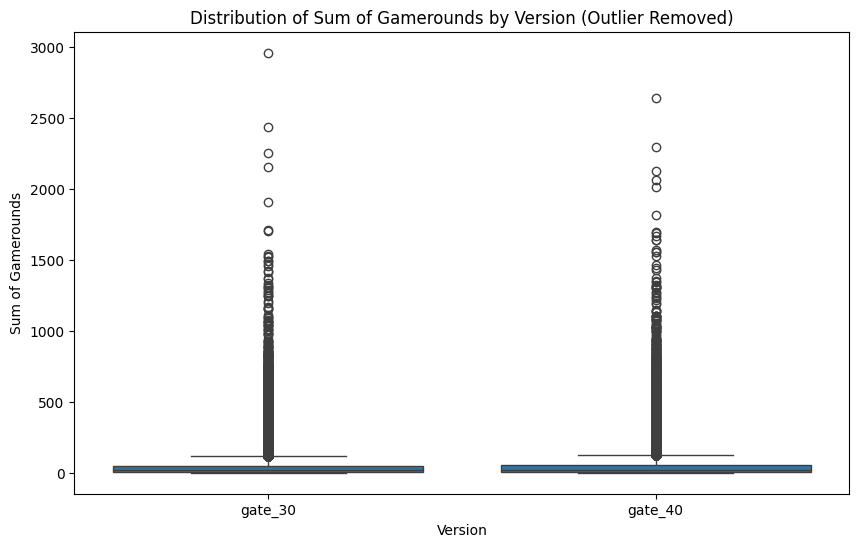

In [ ]:
# View updated distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x='version', y='sum_gamerounds', data=df)
plt.title('Distribution of Sum of Gamerounds by Version (Outlier Removed)')
plt.ylabel('Sum of Gamerounds')
plt.xlabel('Version')
plt.show()

# 2. Check Assumptions for Hypothesis Testing

### Check Assumptions for sum_gamerounds (Quantitative)

To determine what test to use for hypothesis testing on sum_gamerounds, which is a continuous variable, we need to check for homogeneity of variances, as well as Normality.

In [ ]:
# Check for homogeneity of variances using Levene's test
stat, p = stats.levene(df[df['version'] == 'gate_30']['sum_gamerounds'],
                       df[df['version'] == 'gate_40']['sum_gamerounds'])

print(f"Levene's test for homogeneity of variances:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")

if p < 0.05:
    print("Assumption of homogeneity of variances is violated.")
else:
    print("Assumption of homogeneity of variances is met.")

Levene's test for homogeneity of variances:
Statistic: 0.0751, p-value: 0.7840
Assumption of homogeneity of variances is met.



Shapiro-Wilk test for normality (gate_30):
Statistic: 0.4886, p-value: 0.0000

Shapiro-Wilk test for normality (gate_40):
Statistic: 0.4826, p-value: 0.0000

Assumption of normality is likely violated in at least one group.


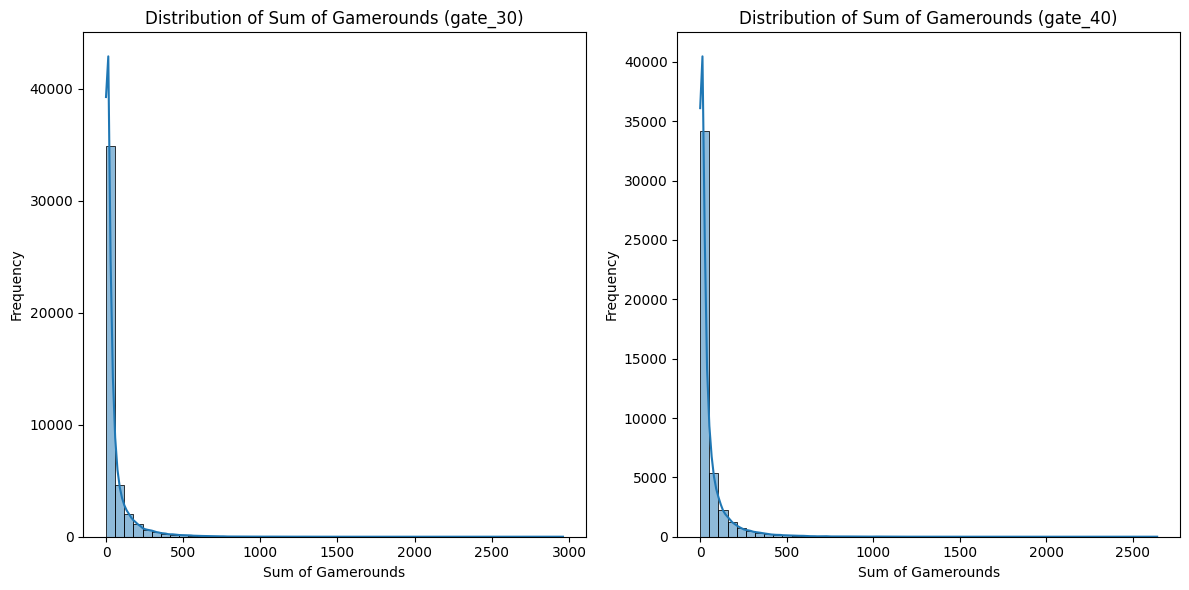

In [ ]:
# Check for normality using Shapiro-Wilk test
# Due to large sample size, Shapiro-Wilk may reject normality even for small deviations.
# Visual inspection (histograms, QQ plots) might be more informative.

shapiro_gate_30_stat, shapiro_gate_30_p = shapiro(df[df['version'] == 'gate_30']['sum_gamerounds'])
shapiro_gate_40_stat, shapiro_gate_40_p = shapiro(df[df['version'] == 'gate_40']['sum_gamerounds'])

print(f"\nShapiro-Wilk test for normality (gate_30):")
print(f"Statistic: {shapiro_gate_30_stat:.4f}, p-value: {shapiro_gate_30_p:.4f}")

print(f"\nShapiro-Wilk test for normality (gate_40):")
print(f"Statistic: {shapiro_gate_40_stat:.4f}, p-value: {shapiro_gate_40_p:.4f}")

if shapiro_gate_30_p < 0.05 or shapiro_gate_40_p < 0.05:
    print("\nAssumption of normality is likely violated in at least one group.")
else:
    print("\nAssumption of normality is met in both groups.")

# Visual check for normality (histograms)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df[df['version'] == 'gate_30']['sum_gamerounds'], kde=True, bins=50)
plt.title('Distribution of Sum of Gamerounds (gate_30)')
plt.xlabel('Sum of Gamerounds')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df[df['version'] == 'gate_40']['sum_gamerounds'], kde=True, bins=50)
plt.title('Distribution of Sum of Gamerounds (gate_40)')
plt.xlabel('Sum of Gamerounds')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Levene's Test indicates that homogeneity is met, but as exepcted our dataset fails the Shapiro-Wilk test for normality.

This was obviously expected since the response variable here is play-time i.e. count data, which is usually skewed.

The absence of normality implies we need to use a non-parametric test. Since our two groups are independent, we want the equivalent of an unpaired t-test.

**The Mann-Whitney U Test would be suitable for this.**

Now let's check the same assumptions for the other measures, retention_1 and retention_7

### Check Assumptions for retention_1 and retention_7 (Binary)

Unlike sum_gamerounds, the retention metrics are binary. This implies we should use a Chi-Square test to compare the group means. The two assumptions we need to check are:
* independence of observations (presupposed)
* expected values (assuming null hypothesis is true) in contingency table should be greater than 5

In [ ]:
# Check assumption of expected frequencies for Chi-Squared test (retention_1)
print("\nExpected frequencies for Chi-Squared test (retention_1):")
contingency_table_ret1 = pd.crosstab(df['version'], df['retention_1'])
chi2_ret1, p_ret1_chi2, dof_ret1, expected_ret1 = stats.chi2_contingency(contingency_table_ret1)
print(pd.DataFrame(expected_ret1, index=['gate_30', 'gate_40'], columns=[False, True]))

# Check assumption of expected frequencies for Chi-Squared test (retention_7)
print("\nExpected frequencies for Chi-Squared test (retention_7):")
contingency_table_ret7 = pd.crosstab(df['version'], df['retention_7'])
chi2_ret7, p_ret7_chi2, dof_ret7, expected_ret7 = stats.chi2_contingency(contingency_table_ret7)
print(pd.DataFrame(expected_ret7, index=['gate_30', 'gate_40'], columns=[False, True]))


Expected frequencies for Chi-Squared test (retention_1):
             False      True 
gate_30 24798.3597 19900.6403
gate_40 25236.6403 20252.3597

Expected frequencies for Chi-Squared test (retention_7):
             False     True 
gate_30 36382.4920 8316.5080
gate_40 37025.5080 8463.4920


Intuitively, these numbers represent the frequencies in both outcomes of retention, assuming H0 is true (i.e. there is no relationship between the group placement and retention).

Had they been too low, it would've implied that a Chi-Square distribution was not suitable for estimating in the first place.

The expected counts for both retention variables in both categories are in the thousands (well over 5). With that, we have satisfied the assumptions for using Chi-Square tests.

# 3. Hypothesis Testing

## Number of Game Rounds as a Metric

In [ ]:
# Perform Mann-Whitney U test
stat, p = stats.mannwhitneyu(df[df['version'] == 'gate_30']['sum_gamerounds'],
                           df[df['version'] == 'gate_40']['sum_gamerounds'],
                           alternative='two-sided') # Using two-sided test as we don't have a specific direction hypothesis

print(f"Mann-Whitney U Test results:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")

# Interpret the results
alpha = 0.05
if p < alpha:
    print("\nReject the null hypothesis: There is a statistically significant difference in the sum of gamerounds between the two versions.")
else:
    print("\nFail to reject the null hypothesis: There is no statistically significant difference in the sum of gamerounds between the two versions.")

Mann-Whitney U Test results:
Statistic: 1024285761.5000, p-value: 0.0509

Fail to reject the null hypothesis: There is no statistically significant difference in the sum of gamerounds between the two versions.


Here we must make an important distinction. The above two-tailed Mann-Whiteney U test led to a failure to reject the null hypothesis.

However, a reconsideration of the A/B Test goals must be made. What was the business question this test sought to answer? If we wanted to test whether player activity specifically *drops* with a higher level cap...

In [ ]:
# Perform Mann-Whitney U test (one-tailed)
stat_one_tailed, p_one_tailed = stats.mannwhitneyu(df[df['version'] == 'gate_30']['sum_gamerounds'],
                           df[df['version'] == 'gate_40']['sum_gamerounds'],
                           alternative='greater') # Testing if gate_30 is greater than gate_40

print(f"Mann-Whitney U Test results (one-tailed):")
print(f"Statistic: {stat_one_tailed:.4f}, p-value: {p_one_tailed:.4f}")

# Interpret the results
alpha = 0.05
if p_one_tailed < alpha:
    print("\nReject the null hypothesis: There is statistically significant evidence that the sum of gamerounds is lower in the gate_40 version compared to gate_30.")
else:
    print("\nFail to reject the null hypothesis: There is no statistically significant evidence that the sum of gamerounds is lower in the gate_40 version compared to gate_30.")

Mann-Whitney U Test results (one-tailed):
Statistic: 1024285761.5000, p-value: 0.0254

Reject the null hypothesis: There is statistically significant evidence that the sum of gamerounds is lower in the gate_40 version compared to gate_30.


7/25/25 note to self: next up:


*   decide on whether two or one tailed
*   then explore other response variables like retention
* then conclude the a/b test results based on those 3 metrics
* 7/26/25: also we check for null user_id's but should we also be checking for null's in other columns (e.g. an empty sum_gamerounds should be dropped)




Here we see that testing whether player activity specifically *drops* DOES yield a statistically significant result. In other words, we have evidence to believe that raising the level gate will result in a drop in player retention.

This disparity highlights the importance of establishing a clear experimental question before running statistical tests.

## Retention as a Metric

Next we can explore whether there is a similar drop in retention with the introduction of a raised level cap.

In [ ]:
# Perform Chi-Squared test for retention_1
contingency_table_ret1 = pd.crosstab(df['version'], df['retention_1'])
chi2_stat_ret1, p_value_ret1, dof_ret1, expected_ret1 = stats.chi2_contingency(contingency_table_ret1)

print(f"Chi-Squared Test results for retention_1:")
print(f"Chi-Squared Statistic: {chi2_stat_ret1:.4f}")
print(f"P-value: {p_value_ret1:.4f}")
print(f"Degrees of Freedom: {dof_ret1}")

# Interpret the results for retention_1
alpha = 0.05
if p_value_ret1 < alpha:
    print("\nReject the null hypothesis: There is a statistically significant difference in 1-day retention between the two versions.")
else:
    print("\nFail to reject the null hypothesis: There is no statistically significant difference in 1-day retention between the two versions.")

Chi-Squared Test results for retention_1:
Chi-Squared Statistic: 3.1698
P-value: 0.0750
Degrees of Freedom: 1

Fail to reject the null hypothesis: There is no statistically significant difference in 1-day retention between the two versions.


In [ ]:
# Perform Chi-Squared test for retention_7
contingency_table_ret7 = pd.crosstab(df['version'], df['retention_7'])
chi2_stat_ret7, p_value_ret7, dof_ret7, expected_ret7 = stats.chi2_contingency(contingency_table_ret7)

print(f"Chi-Squared Test results for retention_7:")
print(f"Chi-Squared Statistic: {chi2_stat_ret7:.4f}")
print(f"P-value: {p_value_ret7:.4f}")
print(f"Degrees of Freedom: {dof_ret7}")

# Interpret the results for retention_7
alpha = 0.05
if p_value_ret7 < alpha:
    print("\nReject the null hypothesis: There is a statistically significant difference in 7-day retention between the two versions.")
else:
    print("\nFail to reject the null hypothesis: There is no statistically significant difference in 7-day retention between the two versions.")

Chi-Squared Test results for retention_7:
Chi-Squared Statistic: 9.9153
P-value: 0.0016
Degrees of Freedom: 1

Reject the null hypothesis: There is a statistically significant difference in 7-day retention between the two versions.


Interestingly, comparing the means between the two experimental groups yields two different answers between the two duration ranges.

Raising the level cap doesn't have a significant impact on player retention past the 1 day mark.

However, raising the cap *does* have a significant impact on player retention past the 1 week mark, with quite a low p-value indicating that the difference is quite pronounced.

## Confidence Intervals
Lastly, let's calculate the confidence intervals for the difference in means for all 3 variables, starting with sum_gamerounds.

Note here that since Normality and therefore parametric assumptions are violated, we must use bootstrap resampling. Put simply, we can estimate the sampling distribution by drawing samples with replacement from the given data.

In [ ]:
# Calculate confidence interval for the difference in means for sum_gamerounds
# Using bootstrap method since normality assumption was violated

n_bootstraps = 1000
bootstrapped_diffs = []

gate_30_rounds = df[df['version'] == 'gate_30']['sum_gamerounds']
gate_40_rounds = df[df['version'] == 'gate_40']['sum_gamerounds']

for i in range(n_bootstraps):
    bootstrap_gate_30 = gate_30_rounds.sample(frac=1, replace=True)
    bootstrap_gate_40 = gate_40_rounds.sample(frac=1, replace=True)
    bootstrapped_diffs.append(bootstrap_gate_30.mean() - bootstrap_gate_40.mean())

# Calculate the 95% confidence interval
confidence_interval_sum_gamerounds = np.percentile(bootstrapped_diffs, [2.5, 97.5])

print(f"95% Confidence Interval for the difference in mean sum_gamerounds (gate_30 - gate_40):")
print(f"{confidence_interval_sum_gamerounds}")

95% Confidence Interval for the difference in mean sum_gamerounds (gate_30 - gate_40):
[-1.27970914  1.40420041]


Note here that the CI includes 0, which implies there is no significant difference between means. This is consistent with our two-tailed Mann-Whitney U Test.

While we are putting more weight on the one-tailed test as it is more relevant to our business question, this confidence interval doesn't necessarily contradict its result. It just highlights that the difference isn't too strong based on a two-sided view.

In [ ]:
# Calculate confidence interval for the difference in proportions for retention_1

count_ret1_gate_30 = df[df['version'] == 'gate_30']['retention_1'].sum()
nobs_ret1_gate_30 = len(df[df['version'] == 'gate_30'])
count_ret1_gate_40 = df[df['version'] == 'gate_40']['retention_1'].sum()
nobs_ret1_gate_40 = len(df[df['version'] == 'gate_40'])

# Use statsmodels for confidence interval for difference in proportions
from statsmodels.stats.proportion import confint_proportions_2indep

ci_ret1_diff = confint_proportions_2indep(count_ret1_gate_30, nobs_ret1_gate_30,
                                        count_ret1_gate_40, nobs_ret1_gate_40,
                                        method='agresti-coull') # Agresti-Coull is a good general method

print(f"95% Confidence Interval for the difference in retention_1 proportions (gate_30 - gate_40):")
print(f"{ci_ret1_diff}")

95% Confidence Interval for the difference in retention_1 proportions (gate_30 - gate_40):
(np.float64(-0.000572196030935973), np.float64(0.012402149583999017))


The CI for 1-day Retention includes 0, which aligns with our testing results implying that 1-day Retention isn't affected by changing the level cap.

In [ ]:
# Calculate confidence interval for the difference in proportions for retention_7

count_ret7_gate_30 = df[df['version'] == 'gate_30']['retention_7'].sum()
nobs_ret7_gate_30 = len(df[df['version'] == 'gate_30'])
count_ret7_gate_40 = df[df['version'] == 'gate_40']['retention_7'].sum()
nobs_ret7_gate_40 = len(df[df['version'] == 'gate_40'])

# Use statsmodels for confidence interval for difference in proportions
from statsmodels.stats.proportion import confint_proportions_2indep

ci_ret7_diff = confint_proportions_2indep(count_ret7_gate_30, nobs_ret7_gate_30,
                                        count_ret7_gate_40, nobs_ret7_gate_40,
                                        method='agresti-coull') # Agresti-Coull is a good general method

print(f"95% Confidence Interval for the difference in retention_7 proportions (gate_30 - gate_40):")
print(f"{ci_ret7_diff}")

95% Confidence Interval for the difference in retention_7 proportions (gate_30 - gate_40):
(np.float64(0.003102840402227294), np.float64(0.01326328472044098))


Lastly, 7-day Retention variable has a CI that does not include 0, again aligning with the result that there is a significant difference between the means of players in the treatment vs. control groups in regards to 7-day retention.

# Conclusions

The impact of raising the level cap from 30 to 40 was measured by two metrics:

1.   The amount of game rounds played
2.   The real life duration that the player continued to open the game

The first metric's distribution was homogenous but not Normal, prompting the usage of the nonparametric Mann-Whitney U Test.

The results yielded different answers based upon whether we used a one-tailed or two-tailed test. Because the former "focuses all of its confidence" in one direction, it's more sensitive to detecting changes, thus our interpretation is that increasing the level cap **does** significantly reduce the average amount of game rounds played by users.

On the other hand, testing for a difference *at all* yields no significant evidence.

The second metric's distribution was binary, prompting the use of the Chi-Square Test. Again, there were different results based on whether we looked at 1-day vs. 7-day retention rates.

While retention rates didn't significantly differ within the 1-day range, they did for the 7-day range, and quite confidently so.

Without dedicating more time and effort to a further A/B Test with extended metrics and duration ranges, the takeaway is as follows:

Raising the level cap has a high enough detrimental influence on the number of game rounds played to be significant, yet also encourages a significant increase in long-term player retention.

As a mobile game whose revenue presumably comes from microtransactions, the decision on whether or not to increase the level cap should be based on whether more game rounds played *or* more time played is more influential in coercing in-game purchases.

## Potential Further Analysis:
* Segmentation:
Often, the impact of an A/B test can vary across different user segments (e.g., new vs. returning users, users from different acquisition channels). With demographic or behavioral data to segment users, analyzing the A/B test results within these segments could provide deeper insights.

* Additional Metrics:
There are likely other relevant metrics which, if enough data has been collected for, can be measurably impacted by moving the gate. Some examples could be purchase conversion rates, screen time spent IN game...

* Adjusting Study Limitations:
Being the first A/B Test Experiment done on this dataset, there were strict limitations on the parameters surrounding the data, e.g. a time frame of only 7 days, only one gate moved, etc. Sourcing more data for metrics such as retention beyond 7 days may also be useful information in determining how to increase revenue.